Data importing 

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download -d crowww/a-large-scale-fish-dataset

a-large-scale-fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip a-large-scale-fish-dataset.zip

Archive:  a-large-scale-fish-dataset.zip
replace Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Importing libraries

In [4]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import segmentation_models as sm
from segmentation_models import get_preprocessing
from sklearn.model_selection import train_test_split
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


**Data importing and separating into images and masks**

In [6]:
images = os.listdir("/content/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat")  #images directory
images.sort()
images = list(images)

In [7]:
masks = os.listdir("/content/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT")  #masks drectory
masks.sort()
masks = list(masks)

In [8]:
x = []                            #importing only 500 images and corresponding masks
count = 0
for i in images:
  if(count==500):
    break
  img = cv.imread(os.path.join("/content/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat",i))
  re = cv.resize(img,(256,256))
  x.append(re)
  count+=1

In [9]:
y =[]
count=0
for i in masks:
  if(count==500):
    break
  label = cv.imread(os.path.join("/content/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT",i),cv.IMREAD_GRAYSCALE)
  l_re = cv.resize(label,(256,256))
  y.append(l_re)
  count+=1

**Data Preparation**

In [10]:
x = np.array(x)
y = np.array(y)

In [11]:
print(x.shape)
print(y.shape)

(500, 256, 256, 3)
(500, 256, 256)


In [12]:
np.unique(y)            #so it is a binary segmentation so i will be assigning pixels greater than 0 and less than 255 as 0 so that i have only 2 labels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [13]:
for i in range(500):          #now the pixels will be 0 and 255
  for j in range(256):
    for k in range(256):
      if(y[i][j][k]>0) and (y[i][j][k]<255):
        y[i][j][k]=0

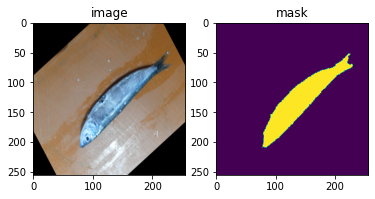

In [14]:
plt.subplot(1,2,1)
plt.title("image")
plt.imshow(x[0])
plt.subplot(1,2,2)
plt.title("mask")
plt.imshow(y[0])

In [15]:
y = y.reshape(500,256,256,1)   #reshaping the mask as the unet model requires 4D input

In [16]:
x = x/255
y = y/255

In [17]:
np.unique(y)      #unique pixels in masks

array([0., 1.])

**Model Building**

In [18]:
backbone = 'resnet34'
pre_process = get_preprocessing(backbone)
model = sm.Unet(backbone_name=backbone,classes=1,activation='sigmoid',encoder_weights='imagenet')

In [19]:
x = pre_process(x)
y = pre_process(y)

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=444)     #splitting the data into training and testing

In [21]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
history = model.fit(x_train,y_train , validation_data=(x_test,y_test),batch_size=8,epochs=5)

Epoch 1/5
50/50 [==============================] - 9s 169ms/step - loss: 0.0107 - accuracy: 0.9956 - val_loss: 0.3885 - val_accuracy: 0.9261
Epoch 2/5
50/50 [==============================] - 8s 170ms/step - loss: 0.0102 - accuracy: 0.9958 - val_loss: 0.2735 - val_accuracy: 0.9431
Epoch 3/5
50/50 [==============================] - 9s 172ms/step - loss: 0.0091 - accuracy: 0.9963 - val_loss: 0.0487 - val_accuracy: 0.9855
Epoch 4/5
50/50 [==============================] - 9s 174ms/step - loss: 0.0089 - accuracy: 0.9964 - val_loss: 0.0172 - val_accuracy: 0.9940
Epoch 5/5
50/50 [==============================] - 9s 174ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.0116 - val_accuracy: 0.9955


**Doing Prediction**

In [33]:
y_pred = model.predict(x_test)

4/4 [==============================] - 0s 142ms/step


In [34]:
y_pred.shape

(100, 256, 256, 1)

**Calculating the IOU score**

In [35]:
n_classes = 2

In [36]:
y_threshold = y_pred>0.5

In [37]:
iou = MeanIoU(num_classes=n_classes)

In [38]:
iou.update_state(y_threshold,y_test)
print("iou score =" ,iou.result().numpy())

iou score = 0.97503984


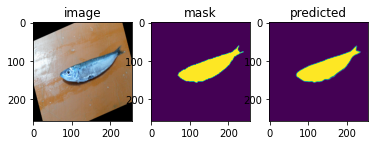

In [39]:
plt.subplot(1,3,1)
plt.title("image")
plt.imshow(x_test[0])
plt.subplot(1,3,2)
plt.title("mask")
plt.imshow(y_test[0,:,:,0])
plt.subplot(1,3,3)
plt.title("predicted")
plt.imshow(y_pred[0,:,:,0])